# YZ Proje Ödevi: Genetik Algoritma ile Kargo Kutusu Optimizasyonu (Senaryo 6)

* **Adı Soyadı:** Bahadır Beldek
* **Öğrenci No:** 2112721066
* **Ders:** BLG-307 Yapay Zeka Sistemleri
* **Github Repo:** https://github.com/mxdd0/genetik-algoritma-kutu-tasarimi

## Proje Tanımı
Bu projede, bir e-ticaret firması için hacmi maksimize ederken maliyeti minimize eden optimum kargo kutusu boyutları ($x_1$: Genişlik, $x_2$: Yükseklik) **Genetik Algoritma** kullanılarak hesaplanmıştır.

## 1. Kütüphanelerin Yüklenmesi ve Parametre Ayarları

Projede sayısal işlemler için `numpy`, sonuçların görselleştirilmesi (grafik çizimi) için `matplotlib` kütüphaneleri kullanılmıştır.

Algoritmanın başarısını etkileyen temel **Hiperparametreler** şunlardır:
* **POPULATION_SIZE (50):** Her nesilde yarışacak birey (kutu tasarımı) sayısı.
* **GENERATIONS (50):** Algoritmanın kaç kuşak boyunca evrimleşeceği.
* **MUTATION_RATE (0.1):** Genetik çeşitliliği korumak için genlerin rastgele değişme ihtimali (%10).
* **Sınırlar (Bounds):** Senaryo 6'da verilen ölçü kısıtlarıdır (Genişlik 10-40 cm, Yükseklik 5-20 cm).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- HİPERPARAMETRELER ---
POPULATION_SIZE = 50   # Popülasyon büyüklüğü
GENERATIONS = 50       # Nesil sayısı
MUTATION_RATE = 0.1    # Mutasyon olasılığı

# Değişkenlerin Sınırları (Senaryo 6)
# x1: Genişlik [10, 40]
X1_BOUNDS = [10, 40]
# x2: Yükseklik [5, 20]
X2_BOUNDS = [5, 20]

## 2. Amaç Fonksiyonu ve Kısıt Yönetimi (Fitness Function)

Problemin amacı, verilen formüldeki $y$ değerini maksimize etmektir:
$$y = x_1 \cdot x_2 - 0.1x_1^2 - 0.1x_2^2$$

### Kısıtların Uygulanması (Penalty Method / Ceza Yöntemi)
Senaryoda belirtilen "fiziksel kısıtlar" şunlardır:
1.  **Raf Sınırı:** Taban alanı ($x_1 \cdot x_2$) 600 $cm^2$'den büyük olamaz.
2.  **Minimum Genişlik:** $x_1$ değeri 15 $cm$'den küçük olamaz.

Bu kısıtları ihlal eden (geçersiz) kutu tasarımlarının seçilmesini engellemek için **Ceza Yöntemi** uygulanmıştır. Kısıtları sağlamayan bireylerin uygunluk puanı (fitness) **-9999** yapılarak, doğal seçilimde elenmeleri ve hayatta kalamamaları sağlanmıştır.

In [2]:
def fitness_function(x1, x2):
    """
    Bu fonksiyon bir kutu tasarımının ne kadar iyi olduğunu hesaplar.
    """
    # 1. Önce Senaryo 6'daki formülü hesaplayalım
    # y = x1*x2 - 0.1*x1^2 - 0.1*x2^2
    score = (x1 * x2) - (0.1 * x1**2) - (0.1 * x2**2)

    # 2. KISITLARIN KONTROLÜ (Penalty Method)

    # Kısıt 1: x1 * x2 <= 600 olmalı
    if (x1 * x2) > 600:
        # Eğer 600'ü geçerse çok büyük ceza veriyoruz.
        return -9999

    # Kısıt 2: x1 >= 15 olmalı
    if x1 < 15:
        # Eğer 15'ten küçükse yine ceza veriyoruz.
        return -9999

    return score

## 3. Popülasyon ve Genetik Operatörler

Genetik Algoritmanın evrim mekanizması şu fonksiyonlarla sağlanır:

1.  **create_initial_population:** Belirlenen sınırlar içinde tamamen rastgele genlere sahip ilk nesli oluşturur.
2.  **tournament_selection (Turnuva Seçimi):** Rastgele seçilen 3 birey arasından en iyisini ebeveyn olarak seçer. Bu yöntem "Seçim Baskısı" oluşturarak iyi genlerin aktarılmasını sağlar.
3.  **crossover (Çaprazlama):** İki ebeveynin genlerini (%50 ihtimalle) karıştırarak yeni bireyler (çocuklar) üretir.
4.  **mutation (Mutasyon):** Yerel maksimum (local optima) tuzağına düşmemek için bireyin genlerinde ufak rastgele değişiklikler yapar.

In [3]:
def create_initial_population():
    population = []
    for _ in range(POPULATION_SIZE):
        # x1 için 10 ile 40 arasında rastgele sayı
        gene1 = np.random.uniform(X1_BOUNDS[0], X1_BOUNDS[1])
        # x2 için 5 ile 20 arasında rastgele sayı
        gene2 = np.random.uniform(X2_BOUNDS[0], X2_BOUNDS[1])
        population.append([gene1, gene2])
    return np.array(population)

# Turnuva Seçimi: Rastgele k tane seç, en iyisini al.
def tournament_selection(population, scores, k=3):
    selection_ix = np.random.randint(len(population))
    for ix in np.random.randint(0, len(population), k-1):
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return population[selection_ix]

# Çaprazlama: İki ebeveynin genlerini karıştırıp çocuk yapma
def crossover(p1, p2):
    c1 = p1.copy()
    c2 = p2.copy()

    # %50 ihtimalle genleri değiş tokuş et
    if np.random.rand() < 0.5:
        c1[1] = p2[1] # c1, 2. genini p2'den alır
        c2[1] = p1[1] # c2, 2. genini p1'den alır

    return [c1, c2]

# Mutasyon: Çocuğun genlerinde ufak rastgele oynamalar yapma
def mutation(individual):
    # x1 geni için mutasyon
    if np.random.rand() < MUTATION_RATE:
        # -1 ile +1 arasında küçük bir değişim ekle
        individual[0] += np.random.uniform(-1, 1)
        # Sınırları aştıysa düzelt (Clamping)
        individual[0] = np.clip(individual[0], X1_BOUNDS[0], X1_BOUNDS[1])

    # x2 geni için mutasyon
    if np.random.rand() < MUTATION_RATE:
        individual[1] += np.random.uniform(-1, 1)
        # Sınırları aştıysa düzelt
        individual[1] = np.clip(individual[1], X2_BOUNDS[0], X2_BOUNDS[1])

    return individual

## 4. Ana Döngü ve Görselleştirme

Bu bölümde algoritma `GENERATIONS` sayısı kadar çalıştırılır. Her adımda:
1.  Bireylerin skorları hesaplanır.
2.  En iyi ve ortalama skorlar grafik çizimi için kaydedilir.
3.  Seçilim, Çaprazlama ve Mutasyon ile yeni nesil üretilir.

Döngü bittiğinde, algoritmanın bulduğu **en iyi genişlik ve yükseklik** değerleri raporlanır ve gelişim grafiği çizdirilir.

Genetik Algoritma Çalışıyor... Lütfen bekleyiniz.

Nesil 0: En İyi Skor = 374.47 | Genişlik=31.65, Yükseklik=15.78
Nesil 10: En İyi Skor = 464.21 | Genişlik=31.01, Yükseklik=19.27
Nesil 20: En İyi Skor = 466.12 | Genişlik=31.06, Yükseklik=19.31
Nesil 30: En İyi Skor = 466.12 | Genişlik=31.06, Yükseklik=19.31
Nesil 40: En İyi Skor = 466.12 | Genişlik=31.06, Yükseklik=19.31

--- OPTİMİZASYON TAMAMLANDI ---
En İyi Genişlik (x1) : 31.0631 cm
En İyi Yükseklik (x2): 19.3154 cm
Maksimum Skor (y)    : 466.1977
Kontrol (Alan x1*x2) : 600.00 (<=600 olmalı)


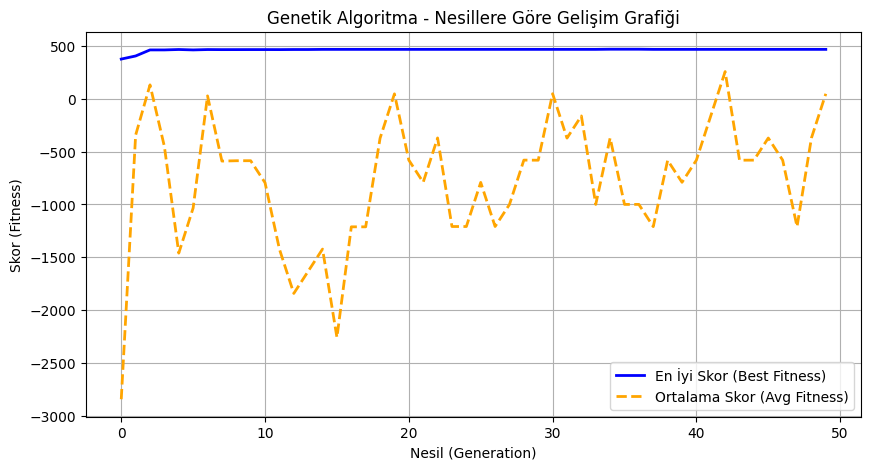

In [4]:
# --- ANA PROGRAM VE DÖNGÜ ---

# 1. İlk popülasyonu yarat (Rastgele 50 kutu)
population = create_initial_population()

# Grafikler için verileri tutacağımız boş listeler
best_scores = []
avg_scores = []

print("Genetik Algoritma Çalışıyor... Lütfen bekleyiniz.\n")

# Nesiller boyunca döngü (50 nesil)
for gen in range(GENERATIONS):

    # 2. Her bireyin puanını (fitness) hesapla
    scores = [fitness_function(ind[0], ind[1]) for ind in population]

    # En iyi sonucu ve ortalamayı kaydet (Grafik için)
    best_score = max(scores)
    avg_score = sum(scores) / len(scores)
    best_scores.append(best_score)
    avg_scores.append(avg_score)

    # Her 10 nesilde bir ekrana bilgi yaz (Süreci takip etmek için)
    if gen % 10 == 0:
        # O neslin en iyi bireyini bul
        best_ind = population[np.argmax(scores)]
        print(f"Nesil {gen}: En İyi Skor = {best_score:.2f} | Genişlik={best_ind[0]:.2f}, Yükseklik={best_ind[1]:.2f}")

    # 3. Yeni nesil oluşturma (Selection -> Crossover -> Mutation)
    new_population = []

    while len(new_population) < POPULATION_SIZE:
        # a. İki ebeveyn seç (Turnuva yöntemiyle)
        parent1 = tournament_selection(population, scores)
        parent2 = tournament_selection(population, scores)

        # b. Çaprazlama yap (Çocuk üret)
        child1, child2 = crossover(parent1, parent2)

        # c. Mutasyon yap (Çocuklarda rastgele değişim)
        child1 = mutation(child1)
        child2 = mutation(child2)

        # Yeni popülasyona ekle
        new_population.append(child1)
        new_population.append(child2)

    # Yeni popülasyona geç
    population = np.array(new_population)

# --- SONUÇLARI GÖSTERME ---
final_scores = [fitness_function(ind[0], ind[1]) for ind in population]
best_index = np.argmax(final_scores)
best_solution = population[best_index]

print("\n" + "="*40)
print("--- OPTİMİZASYON TAMAMLANDI ---")
print("="*40)
print(f"En İyi Genişlik (x1) : {best_solution[0]:.4f} cm")
print(f"En İyi Yükseklik (x2): {best_solution[1]:.4f} cm")
print(f"Maksimum Skor (y)    : {final_scores[best_index]:.4f}")
print(f"Kontrol (Alan x1*x2) : {best_solution[0]*best_solution[1]:.2f} (<=600 olmalı)")

# --- GRAFİK ÇİZİMİ ---
plt.figure(figsize=(10, 5))
plt.plot(best_scores, label='En İyi Skor (Best Fitness)', color='blue', linewidth=2)
plt.plot(avg_scores, label='Ortalama Skor (Avg Fitness)', color='orange', linestyle='--', linewidth=2)
plt.title('Genetik Algoritma - Nesillere Göre Gelişim Grafiği')
plt.xlabel('Nesil (Generation)')
plt.ylabel('Skor (Fitness)')
plt.legend()
plt.grid(True)
plt.show()